In [21]:
#importing important libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [22]:
#funtions for plotting series and (trend, seasonality, white_noise)
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

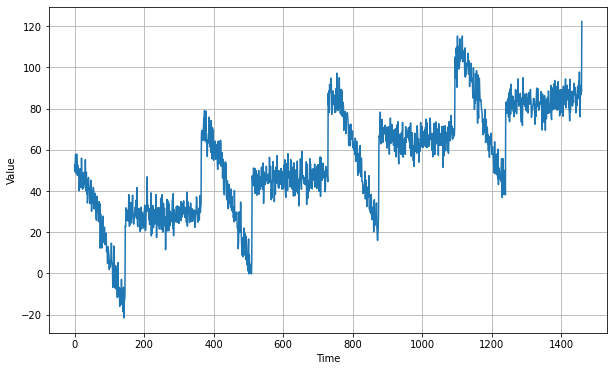

In [23]:
#trend and seasonality
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

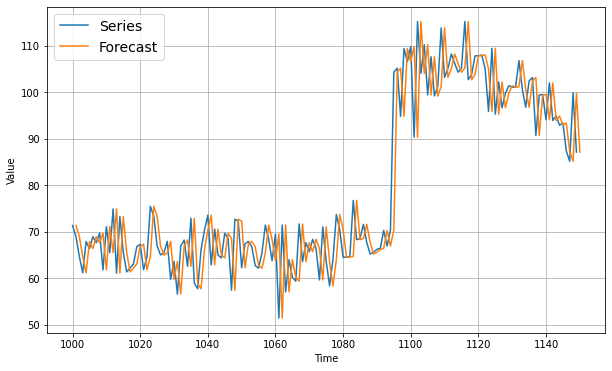

In [24]:
# naive forecasting
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [25]:
#mean absolute error
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

# **MOVING AVERAGE**

In [26]:
#this implementation is much slower 
def moving_average_forecast(series, window_size):
  """ Forecasts the mean of last few values.
      If window_size=1 it works like naive forecasting"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [27]:
def adv_moving_average_forecast(series, window_size):
  """ Forecasts the mean of last few values.
      If window_size=1 it works like naive forecasting
      This implementation is much faster than the previous one"""
  mov = np.cumsum(series) #it is function for cumulative sum and because of this
  #our implementation is approx. 300 times faster than the previous one
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1: -1] / window_size

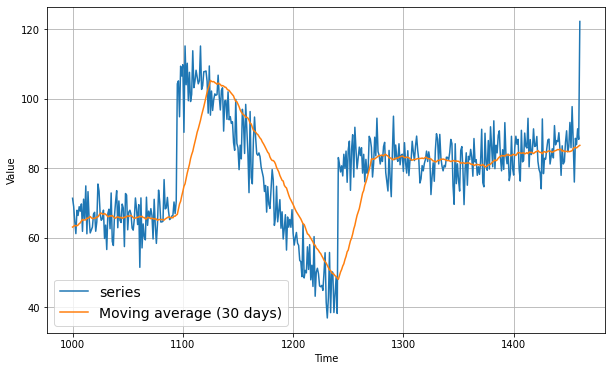

In [28]:
#forecasting with the winow size of the past 30 days
moving_avg = adv_moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

#Much smoother result than naive forecasting but they are not anticipating at all (trend or seasonality)
# this results in a delay between the forecast and the actual values 
# and which results in a performance much worse than the naive forecasting

In [29]:
#performance(error)
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

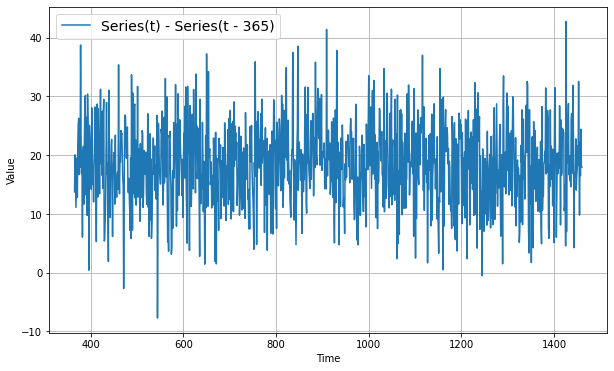

In [30]:
# we can improve performance by using a technique called differencing and remove
# trend and seasonality, since seasonality is 365 days, we will subtract
#value at time t-365 from the value at time t

diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) - Series(t - 365)")
plt.show()

#the graph looks mostly like noise (good) which means that we have captured most of 
#the signal by using differencing

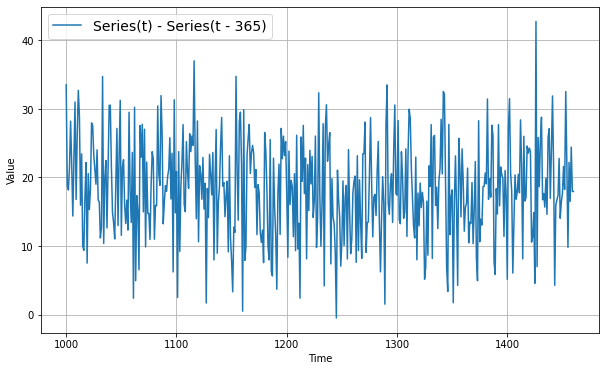

In [31]:
#focusing on the validation period for better understanding
plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) - Series(t - 365)")
plt.show()

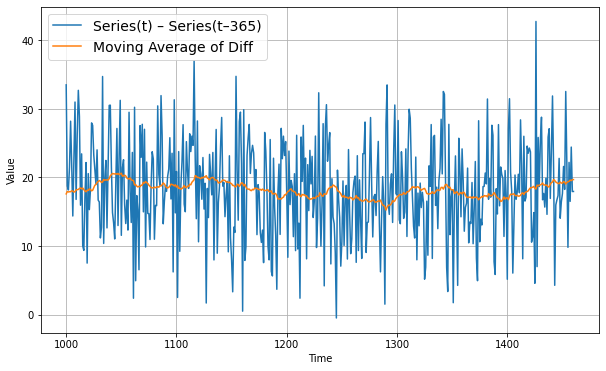

In [32]:
#from analysis trend and seasonality seems to be gone
# now using moving_average
diff_moving_avg = adv_moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()
#now it is predicting  most of the things

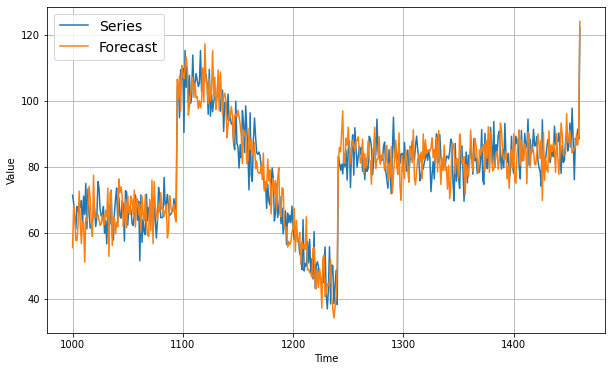

In [33]:
#Now bringingback the trend ans seasonality to our series by adding past values from t - 365 
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label = "Forecast")
plt.show()

In [34]:
# now it is predicting most of the things and looks more accurate
#performance
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()
# gives a little better performance but not much
# the data plotted above is also too random because we have just added past values
# which were way too noisy

5.8393105629958955

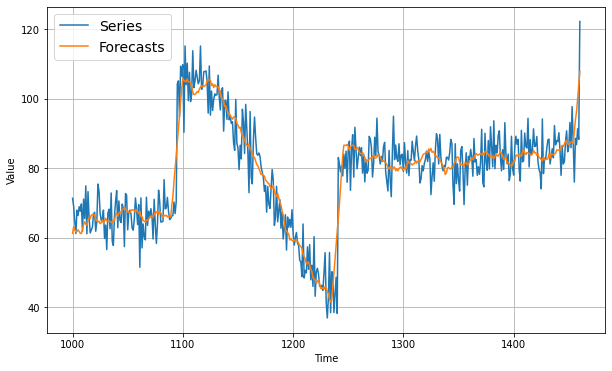

In [35]:
#we will be using moving_avg again to remove the noise
diff_moving_avg_plus_smooth_past = adv_moving_average_forecast(series[split_time - 370: -359], 11) + diff_moving_avg
#computing moving avg of 1 year ago +- 15 days

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()
#after applying moving average it looks much better

In [36]:
#performance
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()
#best performance for now will be optimizing

4.566859958970772